# Soen 471 Project: Predict a Player’s Position (Forward, Midfielder, Defender, or Goalkeeper) Based on Their Different Skill Ratings.

## Data Processing

### Import libraries

In [62]:
import pandas as pd
import matplotlib.pyplot as pl
import pathlib
import shutil
import numpy as np
import pyspark.sql.functions as F
import findspark
import os
import sys

from data_processing import *
from datetime import datetime

from IPython.display import display

from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, when, col
from pyspark.ml.classification import DecisionTreeClassifier as DTC, RandomForestClassifier as RFC
from pyspark.sql.functions import array, col, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer,VectorAssembler

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Spark Initialization/ Setup environment

In [63]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

findspark.init()


# Initialize a spark session.
def init_spark():
    spark = (
        SparkSession.builder.appName("SOEN 471 Project")
        .config("spark.some.config.option", "some-value")
        .getOrCreate()
    )
    return spark

### Sample of Initial Data

<p>Initial row count is of 10,003,590 values.</p>

In [64]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

spark = init_spark()

df1 = spark.read.csv(os.path.join(data_dir, 'male_players1.csv'), header=True)
df2 = spark.read.csv(os.path.join(data_dir, 'male_players2.csv'), header=True)
df3 = spark.read.csv(os.path.join(data_dir, 'male_players3.csv'), header=True)
df4 = spark.read.csv(os.path.join(data_dir, 'male_players4.csv'), header=True)
df5 = spark.read.csv(os.path.join(data_dir, 'male_players5.csv'), header=True)
df6 = spark.read.csv(os.path.join(data_dir, 'male_players6.csv'), header=True)

players_set = df1.union(df2).union(df3).union(df4).union(df5).union(df6)

sample = players_set.take(5)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
sample = sample.drop(sample.columns[0], axis=1)

display(sample)

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/230009,23,9,2023-01-13,L. Messi,Lionel Andrés Messi Cuccittini,RW,91,91,...,63+3,63+3,64+3,59+3,50+3,50+3,50+3,59+3,19+3,https://cdn.sofifa.net/players/158/023/23_120.png
1,165153,/player/165153/karim-benzema/230009,23,9,2023-01-13,K. Benzema,Karim Benzema,"CF, ST",91,91,...,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,https://cdn.sofifa.net/players/165/153/23_120.png
2,188545,/player/188545/robert-lewandowski/230009,23,9,2023-01-13,R. Lewandowski,Robert Lewandowski,ST,91,91,...,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/23_120.png
3,192985,/player/192985/kevin-de-bruyne/230009,23,9,2023-01-13,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,79+3,79+3,78+3,74+3,68+3,68+3,68+3,74+3,21+3,https://cdn.sofifa.net/players/192/985/23_120.png
4,231747,/player/231747/kylian-mbappe/230009,23,9,2023-01-13,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,95,...,63+3,63+3,67+3,63+3,54+3,54+3,54+3,63+3,18+3,https://cdn.sofifa.net/players/231/747/23_120.png


### Feature Selection

<p>Selects all field-related features relevant to our model and removes unnecessary characteristics such as player name, height, age, net worth, etc.</p>

In [65]:
players_set = players_set.select(
        "player_positions",
        "overall",
        "skill_moves",
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending",
        "physic",
        "attacking_crossing",
        "attacking_finishing",
        "attacking_heading_accuracy",
        "attacking_short_passing",
        "attacking_volleys",
        "skill_dribbling",
        "skill_curve",
        "skill_fk_accuracy",
        "skill_long_passing",
        "skill_ball_control",
        "movement_acceleration",
        "movement_sprint_speed",
        "movement_agility",
        "movement_reactions",
        "movement_balance",
        "power_shot_power",
        "power_jumping",
        "power_stamina",
        "power_strength",
        "power_long_shots",
        "mentality_aggression",
        "mentality_interceptions",
        "mentality_positioning",
        "mentality_vision",
        "mentality_penalties",
        "mentality_composure",
        "defending_marking_awareness",
        "defending_standing_tackle",
        "defending_sliding_tackle",
        "goalkeeping_diving",
        "goalkeeping_handling",
        "goalkeeping_kicking",
        "goalkeeping_positioning",
        "goalkeeping_reflexes",
        "goalkeeping_speed",
    )

sample = players_set.take(10)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,player_positions,overall,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,RW,91,4,81.0,89.0,90.0,94.0,34.0,64.0,84,...,96,20,35,24,6,11,15,14,8,None
1,"CF, ST",91,4,80.0,88.0,83.0,87.0,39.0,78.0,75,...,90,43,24,18,13,11,5,5,7,None
2,ST,91,4,75.0,91.0,79.0,86.0,44.0,83.0,71,...,88,35,42,19,15,6,12,8,10,None
3,"CM, CAM",91,4,74.0,88.0,93.0,87.0,63.0,77.0,94,...,89,65,65,53,15,13,5,10,13,None
4,"ST, LW",91,5,97.0,89.0,80.0,92.0,36.0,76.0,78,...,88,26,34,32,13,5,7,11,6,None
5,GK,90,1,None,None,None,None,None,None,14,...,66,20,18,16,84,89,75,89,90,46.0
6,RW,90,4,90.0,89.0,82.0,90.0,45.0,75.0,80,...,92,38,43,41,14,14,9,11,14,None
7,GK,89,1,None,None,None,None,None,None,15,...,70,17,10,11,87,88,90,88,87,49.0
8,LW,89,5,87.0,83.0,85.0,93.0,37.0,61.0,83,...,93,35,32,29,9,9,15,15,11,None
9,CDM,89,2,63.0,73.0,78.0,73.0,88.0,89.0,62,...,84,90,88,87,13,14,16,12,12,None


<p>As seen above, most players have more than one preferred position, displayed in increasing order. We therefore filter through the positions and return only the most preferred, creating a new column and dropping the previous one.</p>

In [66]:
players_set = players_set.withColumn(
        "player_position", split(players_set["player_positions"], ",")[0]
    ).drop("player_positions")

sample = players_set.select(players_set.columns[-1]).take(10)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,player_position
0,RW
1,CF
2,ST
3,CM
4,ST
5,GK
6,RW
7,GK
8,LW
9,CDM


<p>For players whose position is goalkeeper, important attribute fields are empty, such as shooting, passing, dribbling, defending, etc. We therefore remove all goal-keeping related attributes and goal-keepers from our data selection.</p>

<p>Reduces our row count from <b>10,003,590</b> to <b>8,882,644</b>.</p>

In [67]:
players_set = players_set.drop(
        "goalkeeping_diving",
        "goalkeeping_handling",
        "goalkeeping_kicking",
        "goalkeeping_positioning",
        "goalkeeping_reflexes",
        "goalkeeping_speed",
    ).filter(players_set.player_position != "GK")

sample = players_set.take(10)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,overall,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,player_position
0,91,4,81.0,89.0,90.0,94.0,34.0,64.0,84,90,...,44,40,93,94,75,96,20,35,24,RW
1,91,4,80.0,88.0,83.0,87.0,39.0,78.0,75,92,...,63,39,92,89,84,90,43,24,18,CF
2,91,4,75.0,91.0,79.0,86.0,44.0,83.0,71,94,...,81,49,94,81,90,88,35,42,19,ST
3,91,4,74.0,88.0,93.0,87.0,63.0,77.0,94,85,...,75,64,88,94,83,89,65,65,53,CM
4,91,5,97.0,89.0,80.0,92.0,36.0,76.0,78,93,...,64,38,92,83,80,88,26,34,32,ST
5,90,4,90.0,89.0,82.0,90.0,45.0,75.0,80,93,...,63,55,92,85,86,92,38,43,41,RW
6,89,5,87.0,83.0,85.0,93.0,37.0,61.0,83,83,...,63,37,86,90,91,93,35,32,29,LW
7,89,2,63.0,73.0,78.0,73.0,88.0,89.0,62,64,...,91,88,75,79,66,84,90,88,87,CDM
8,89,3,69.0,91.0,83.0,83.0,47.0,82.0,80,93,...,80,44,94,87,92,92,50,36,38,ST
9,89,2,81.0,60.0,71.0,72.0,90.0,86.0,53,52,...,85,89,47,65,62,90,91,91,86,CB


<p>We then drop features which are not discriminative towards any of the labels, and where same values can easily be obtained between players of all classes.</p>

In [68]:
players_set = players_set.drop(
        "overall",
        "skill_moves",
        "physic",
        "skill_curve",
        "movement_reactions",
        "power_jumping",
        "power_strength",
        "mentality_aggression",
        "mentality_vision",
        "mentality_composure",
    )

sample = players_set.take(5)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_shot_power,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,player_position
0,81.0,89.0,90.0,94.0,34.0,84,90,70,91,88,...,86,70,91,40,93,75,20,35,24,RW
1,80.0,88.0,83.0,87.0,39.0,75,92,90,89,88,...,87,82,80,39,92,84,43,24,18,CF
2,75.0,91.0,79.0,86.0,44.0,71,94,91,84,89,...,91,76,84,49,94,90,35,42,19,ST
3,74.0,88.0,93.0,87.0,63.0,94,85,55,93,83,...,92,89,91,64,88,83,65,65,53,CM
4,97.0,89.0,80.0,92.0,36.0,78,93,72,85,83,...,88,87,82,38,92,80,26,34,32,ST


### Label Conversion

Converts FIFA-defined positions to one of our three labels:

In [69]:
def label_conversion(player_position):
    player_position = (
        when(player_position.isin(["CB", "RB", "LB", "RWB", "LWB"]), "Defender")
        .when(player_position.isin(["CM", "CDM", "CAM", "RM", "LM"]), "Midfielder")
        .when(player_position.isin(["ST", "CF", "RF", "LF", "RW", "LW"]), "Forward")
        .otherwise("Undefined")
    )

    return player_position

<p>Converts specific positions such as RW, CDM, LB to a more general label (defender, midfielder or forward):</p>

In [70]:
players_set = players_set.withColumn(
        "label_position", label_conversion(players_set["player_position"])
    ).drop("player_position")

sample = players_set.select(players_set.columns[-1]).take(10)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)


,label_position
0,Forward
1,Forward
2,Forward
3,Midfielder
4,Forward
5,Forward
6,Forward
7,Midfielder
8,Forward
9,Defender


<p>We complete the data preparation phase by dropping rows containing null values or a label position of "Undefined". No undefined positions were counted but removing nulls minimally reduces our row count from <b>8,882,644</b> to <b>8,882,438</b>.</p>

In [71]:
players_set = players_set.dropna()

### Data Sampling

<p>As an attempt to improve results, we undersample the data to reduce class imbalance, returning <b>1,476</b> player values for each of the three classes (also easily splittable into two thirds training and one third testing).</p>

In [73]:
defenders = players_set.filter(players_set.label_position == "Defender")
midfielders = players_set.filter(players_set.label_position == "Midfielder")

In [74]:
defenders = defenders.sample(fraction= 1500 / defenders.count()).limit(500)
midfielders = midfielders.sample(fraction=500 / midfielders.count()).limit(500)
forwards = forwards.sample(fraction=500 / forwards.count()).limit(500)

sampled_players = defenders.union(midfielders).union(forwards)

print("Defenders: {}".format(defenders.count()))
print("Midfielders: {}".format(midfielders.count()))
print("Forwards: {}".format(forwards.count()))
print("Total number of sampled players: {}".format(sampled_players.count()))

Defenders: 500
Midfielders: 477
Forwards: 499
Total number of sampled players: 1476


## Supervised Classification Algorithms

<p>Males_players.csv dataset is used to train a Decision Tree model, a Random Forest Model, and a K-nearest neighbors (K-NN) model . The dataset is first preprocessed by encoding the categorical label data to numerical values column. Next, these models are trained on a training set that consists of 2/3 of the dataset, and evaluated by the remaining 1/3 of the dataset, the test set, to evaluate the performance of the trained model.Lastly, classification report and confusion matrix are generated to assess the accuracy and quality of the trained models.</p>

<p>Override the <b>printf()</b> function to display output with time</p>

In [75]:
def printf(*arg, **kwarg):
    timestamp = datetime.now().strftime("%H:%M:%S.%f")
    print(f'[{timestamp}]', *arg, **kwarg)

### Categorical Encoding

<p>Categorical encoding is done to the label_position column before splitting, fitting and evaluating the random forest model by using StringIndexer, which converts textual data to numeric data while keeping its categorical context

In [76]:
players = sampled_data()
def encode(players):
    # Apply string indexer
    indexer = StringIndexer(inputCol="label_position", outputCol="label_position_index")
    return indexer.fit(players).transform(players)
df = encode(players)

The table below displays the resulting dataset after assigning numerical values 0, 1 and 2 to the label positions <b>"Forward"</b>, <b>"Midfielder"</b> and <b>"Defender"</b>, respectively.</p>

In [77]:
unique_values = [row['label_position'] for row in df.select('label_position').distinct().orderBy('label_position').collect()]
for value in unique_values:
    sample = df[df['label_position'] == value].head(1)
    sample = pd.DataFrame(sample, columns=sample[0].__fields__)
    display(sample)

,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index
0,57,29,52,48,63,44,26,62,56,33,...,65,20,60,40,48,66,63,60,Defender,0.0


,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index
0,80,69,61,66,38,58,70,68,65,66,...,64,68,34,70,60,32,37,36,Forward,2.0


,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index
0,73,59,58,65,44,54,60,59,63,42,...,53,55,46,59,53,40,44,32,Midfielder,1.0


<p>To prepare the input data for the random forest model, the "<b>label_position</b>" and "<b>label_position_index</b>" columns are removed, and a new list of DataFrame columns called "<b>list_of_features</b>" is created</p>

In [78]:
# Drop the label_position column to only get the features
def getFeatures(df):
    list_of_features = df.drop("label_position").drop("label_position_index").columns
    assembler = VectorAssembler(inputCols=list_of_features, outputCol="indexed_features")
    df = assembler.transform(df)
    return df
df = getFeatures(df)
# Display the DataFrame
sample = df.take(5)
sample = pd.DataFrame(sample, columns=sample[0].__fields__)
display(sample)

,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index,indexed_features
0,57,29,52,48,63,44,26,62,56,33,...,20,60,40,48,66,63,60,Defender,0.0,"[57.0, 29.0, 52.0, 48.0, 63.0, 44.0, 26.0, 62...."
1,75,45,59,71,66,66,35,58,63,37,...,52,66,62,38,67,68,68,Defender,0.0,"[75.0, 45.0, 59.0, 71.0, 66.0, 66.0, 35.0, 58...."
2,63,57,62,58,65,65,52,67,65,40,...,57,63,37,71,64,67,64,Defender,0.0,"[63.0, 57.0, 62.0, 58.0, 65.0, 65.0, 52.0, 67...."
3,86,61,63,70,66,66,60,56,66,58,...,56,67,67,44,69,68,60,Defender,0.0,"[86.0, 61.0, 63.0, 70.0, 66.0, 66.0, 60.0, 56...."
4,85,59,56,63,59,62,55,64,58,57,...,57,53,57,47,58,63,57,Defender,0.0,"[85.0, 59.0, 56.0, 63.0, 59.0, 62.0, 55.0, 64...."


### Split the data set into a training set and test set

<p>To train the Random Forest Model, a training set is created using 2/3 of the dataset, while the remaining 1/3 is used as the test set.</p>

In [79]:
trainingSet, testSet = df.randomSplit([0.67, 0.33], 24)
# Drop labels of the test set to evaluate later
unlabeledTestSet, testSetRealLabels = testSet.drop(
        "label_position"
    ), testSet.select("label_position").withColumnRenamed(
        "label_position", "real_label"
    )

<p>After splitting, the trainning set and test set will look as showned below:</p>

In [80]:
trainingDataSample= trainingSet.take(10)
trainingDataSample= pd.DataFrame(sample, columns=trainingDataSample[0].__fields__)
testDataSample= testSet.take(10)
testDataSample= pd.DataFrame(sample, columns=testDataSample[0].__fields__)
print("Training Data Sample")
display(trainingDataSample)
print("Test Data Sample")
display(testDataSample)

Training Data Sample


,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index,indexed_features
0,57,29,52,48,63,44,26,62,56,33,...,20,60,40,48,66,63,60,Defender,0.0,"[57.0, 29.0, 52.0, 48.0, 63.0, 44.0, 26.0, 62...."
1,75,45,59,71,66,66,35,58,63,37,...,52,66,62,38,67,68,68,Defender,0.0,"[75.0, 45.0, 59.0, 71.0, 66.0, 66.0, 35.0, 58...."
2,63,57,62,58,65,65,52,67,65,40,...,57,63,37,71,64,67,64,Defender,0.0,"[63.0, 57.0, 62.0, 58.0, 65.0, 65.0, 52.0, 67...."
3,86,61,63,70,66,66,60,56,66,58,...,56,67,67,44,69,68,60,Defender,0.0,"[86.0, 61.0, 63.0, 70.0, 66.0, 66.0, 60.0, 56...."
4,85,59,56,63,59,62,55,64,58,57,...,57,53,57,47,58,63,57,Defender,0.0,"[85.0, 59.0, 56.0, 63.0, 59.0, 62.0, 55.0, 64...."


Test Data Sample


,pace,shooting,passing,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,power_long_shots,mentality_interceptions,mentality_positioning,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,label_position,label_position_index,indexed_features
0,57,29,52,48,63,44,26,62,56,33,...,20,60,40,48,66,63,60,Defender,0.0,"[57.0, 29.0, 52.0, 48.0, 63.0, 44.0, 26.0, 62...."
1,75,45,59,71,66,66,35,58,63,37,...,52,66,62,38,67,68,68,Defender,0.0,"[75.0, 45.0, 59.0, 71.0, 66.0, 66.0, 35.0, 58...."
2,63,57,62,58,65,65,52,67,65,40,...,57,63,37,71,64,67,64,Defender,0.0,"[63.0, 57.0, 62.0, 58.0, 65.0, 65.0, 52.0, 67...."
3,86,61,63,70,66,66,60,56,66,58,...,56,67,67,44,69,68,60,Defender,0.0,"[86.0, 61.0, 63.0, 70.0, 66.0, 66.0, 60.0, 56...."
4,85,59,56,63,59,62,55,64,58,57,...,57,53,57,47,58,63,57,Defender,0.0,"[85.0, 59.0, 56.0, 63.0, 59.0, 62.0, 55.0, 64...."


### Train a model using PySpark

#### Training Decision Tree model

<p>We'll train the model using the code below.<p>

In [81]:
dt = DTC(labelCol="label_position_index", featuresCol="indexed_features", impurity="entropy",
                                maxDepth=15)
printf("Training Decision Tree model...")
model = dt.fit(trainingSet)
printf("Finished fitting model.")
printf("Predicting test labels...")
spark_dt_predictions = model.transform(testSet)
printf("Finished predictions.")

[13:44:17.424458] Training Decision Tree model...
[13:45:27.166608] Finished fitting model.
[13:45:27.166608] Predicting test labels...
[13:45:27.232106] Finished predictions.


#### Training Random Forest  model

<p>We'll train the model using the code below.<p>

In [82]:
rf = RFC(labelCol="label_position_index", featuresCol="indexed_features", numTrees=10, maxDepth=5)
printf("Training Random Forest model...")
model = rf.fit(trainingSet)
printf("Finished fitting model.")
printf("Predicting test labels...")
spark_rf_predictions = model.transform(testSet)
printf("Finished predictions.")

[13:45:38.999871] Training Random Forest model...
[13:47:20.555901] Finished fitting model.
[13:47:20.555901] Predicting test labels...
[13:47:20.611428] Finished predictions.


#### K-nearest neighbors algorithm (K-NN)

<p>Since the K-NN model uses distance between data points to predict an unlabeled data point, we need a function to compute their distance as shown below<p> 

In [83]:
def euclidean_distance(v1, v2):
    return np.sum((v1 - v2) ** 2)

<p>We'll train the model using the code below.<p>

In [84]:
def knnModel(trainingSet, toPredictSet, k):
    # Convert features to vectors to compute their distances 
    featuresArray = array(
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending",
        "attacking_crossing",
        "attacking_finishing",
        "attacking_heading_accuracy",
        "attacking_short_passing",
        "attacking_volleys",
        "skill_dribbling",
        "skill_fk_accuracy",
        "skill_long_passing",
        "skill_ball_control",
        "movement_acceleration",
        "movement_sprint_speed",
        "movement_agility",
        "movement_balance",
        "power_shot_power",
        "power_stamina",
        "power_long_shots",
        "mentality_interceptions",
        "mentality_positioning",
        "mentality_penalties",
        "defending_marking_awareness",
        "defending_standing_tackle",
        "defending_sliding_tackle",
    )
    # Convert the training set into a DataFrame with two columns: 
    # one column represents feature vectors, and the other column represents a player's position.
    trainingSetDf = trainingSet.select(
        featuresArray.alias("features_in_array_training"), "label_position"
    )
    # Drop labels of the test set and convert its features into vectors
    toPredictSetDf = toPredictSet.select(
        monotonically_increasing_id().alias("id"),
        featuresArray.alias("features_in_array_predict"),
    )
    # Compute cartesian product of two Dataframes
    merged = toPredictSetDf.crossJoin(trainingSetDf)
    mergedRDD = merged.rdd
    mergedRDD = mergedRDD.map(
        lambda r: [
            r.id,
            euclidean_distance(
                np.array(r.features_in_array_predict).astype(float),
                np.array(r.features_in_array_training).astype(float),
            ).tolist(),
            r.label_position,
        ]
    )
    merged = mergedRDD.toDF(["id", "distance", "label_position"])
    
    windowMerged = Window.partitionBy("id").orderBy(col("distance").asc())
    merged = (
        merged.withColumn("row", row_number().over(windowMerged))
        .filter(col("row") <= k)
        .drop("row")
        .drop("distance")
    )
    # Get distances between an unlabeled data point with its K nearest neighbors
    merged = merged.groupBy(["id", "label_position"]).count()
    windowMerged = Window.partitionBy("id").orderBy(col("count").desc())
    # Obtain the majority labels of its K nearest neighbors
    merged = (
        merged.withColumn("row", row_number().over(windowMerged))
        .filter(col("row") == 1)
        .drop("row")
        .drop("count")
    )
    merged = merged.orderBy("id").drop("id")
    merged = merged.withColumnRenamed("label_position", "prediction")
    return merged

<p>Now we will train our model using the training set<p>

In [86]:
trainingData = trainingSet.drop("label_position_index").drop("indexed_features")
unlabeledTestData = unlabeledTestSet.drop("label_position_index").drop("indexed_features")
printf("Predicting test labels...")
testSetPredictions = knnModel(trainingData,unlabeledTestData,k=3)
printf("Finished predictions.")

### Model Evaluation

The model will be evaluated as shown below:

In [87]:
def evaluation(testSetLabels, predictions, features):
    # Compute evaluation metrics
    cr = classification_report(testSetLabels,predictions, output_dict=True)
    report_df = pd.DataFrame.from_dict(cr).transpose()
    print("Classification Report:")
    print(report_df)
    cm = confusion_matrix(testSetLabels, predictions)
    print("\nConfusion Matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = features)
    disp.plot()
    pl.show()


#### Evaluate a model trained by Decision Tree algorithm

<p>To generate the classification report, the "<b>prediction</b>" and "<b>label_position_index</b>" columns are selected from the "<b>predictions</b>" dataframe. The resulting DataFrame is then converted to a Pandas dataframe, allowing the use of the <b>classification_report()</b> function from the scikit-learn metrics module.<p>

[13:49:55.750658] Evaluating predictions...

Classification Report:
              precision    recall  f1-score     support
0.0            0.848684  0.826923  0.837662  156.000000
1.0            0.656051  0.647799  0.651899  159.000000
2.0            0.772727  0.804054  0.788079  148.000000
accuracy       0.758099  0.758099  0.758099    0.758099
macro avg      0.759154  0.759592  0.759214  463.000000
weighted avg   0.758252  0.758099  0.758019  463.000000

Confusion Matrix


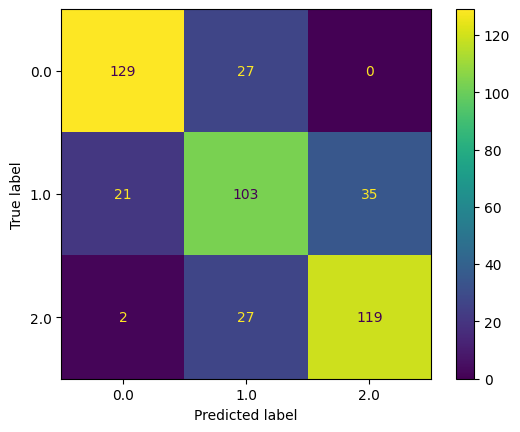

In [88]:
# Compute evaluation metrics
printf("Evaluating predictions...\n")
dt_predictions_and_labels_pd = spark_dt_predictions.select("prediction", "label_position_index").toPandas()
evaluation(dt_predictions_and_labels_pd['label_position_index'],dt_predictions_and_labels_pd['prediction'], [0.0,1.0,2.0])

#### Evaluate a model trained by Random Forest algorithm

<p>To generate the classification report, the "<b>prediction</b>" and "<b>label_position_index</b>" columns are selected from the "<b>predictions</b>" dataframe. The resulting DataFrame is then converted to a Pandas dataframe, allowing the use of the <b>classification_report()</b> function from the scikit-learn metrics module.</p>

[13:51:46.582167] Evaluating predictions...

Classification Report:
              precision    recall  f1-score     support
0.0            0.854305  0.826923  0.840391  156.000000
1.0            0.727848  0.723270  0.725552  159.000000
2.0            0.844156  0.878378  0.860927  148.000000
accuracy       0.807775  0.807775  0.807775    0.807775
macro avg      0.808770  0.809524  0.808957  463.000000
weighted avg   0.807634  0.807775  0.807518  463.000000

Confusion Matrix


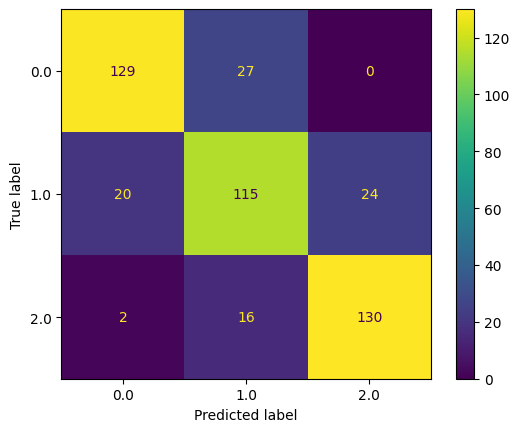

In [90]:
# Compute evaluation metrics
printf("Evaluating predictions...\n")
rf_predictions_and_labels_pd = spark_rf_predictions.select("prediction", "label_position_index").toPandas()
evaluation(rf_predictions_and_labels_pd['label_position_index'],rf_predictions_and_labels_pd['prediction'],[0.0,1.0,2.0])

#### Evaluate a model trained by K-nearest neighbors (K-NN) algorithm 

[13:54:17.066865] Evaluating predictions...

Classification Report:
              precision    recall  f1-score     support
Defender       0.886667  0.852564  0.869281  156.000000
Forward        0.821918  0.810811  0.816327  148.000000
Midfielder     0.706587  0.742138  0.723926  159.000000
accuracy       0.801296  0.801296  0.801296    0.801296
macro avg      0.805057  0.801838  0.803178  463.000000
weighted avg   0.804128  0.801296  0.802437  463.000000

Confusion Matrix


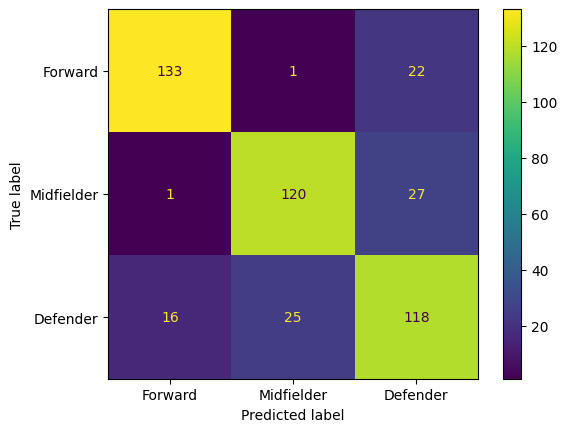

In [92]:
# Compute evaluation metrics
printf("Evaluating predictions...\n")
evaluation(testSetRealLabels.toPandas(),testSetPredictions.toPandas(), ['Forward', 'Midfielder', 'Defender'])

<p><b>Observation:</b> Our models have been trained on a subsample of <bo>1,476</b> data points, which are much smaller than the original dataset. However, increasing the size of the subsample can take hours to train a model. As a result, we have decided to use Apache Parquet, which can generate lower storage costs for data and maximize the effectiveness of data queries. This allows a large amount of data to fit in memory, reducing the time for swapping data from disks. We will save the training set and test set as .parquet. This process is done as shown below:</p>

In [93]:
def cleanup_data_and_store_as_parquet(players):
    trainingSet, testSet = players.randomSplit([0.67, 0.33], 24)
    male_players_cleaned_training = pathlib.Path("../data/male_players_cleaned_training")
    if male_players_cleaned_training.exists():
         shutil.rmtree("../data/male_players_cleaned_training",ignore_errors=True)
    male_players_cleaned_test = pathlib.Path("../data/male_players_cleaned_test")
    if male_players_cleaned_test.exists():
        shutil.rmtree("../data/male_players_cleaned_test",ignore_errors=True)
        
    trainingSet.write.parquet('../data/male_players_cleaned_training')
    testSet.write.parquet('../data/male_players_cleaned_test') 

# Read the dataset using PySpark
players = data_preparation("../data/male_players.csv")
cleanup_data_and_store_as_parquet(players)
printf("-------Using the entire of data set-------")
printf("Loading dataset...")

# Convert to Pandas Dataframe to train with Scikit-Learn later
trainingSet = pd.read_parquet('../data/male_players_cleaned_training')
testSet = pd.read_parquet('../data/male_players_cleaned_test')
printf(f'Finished loading dataset. Training set: {trainingSet.shape[0]} rows, Test set: {testSet.shape[0]} rows')

# Get labels of the training set
trainingSetLabels = trainingSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the training set 
trainingSet = trainingSet.iloc[:, :-1]

# Get labels of the test set
testSetLabels = testSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the test set
testSet = testSet.iloc[:, :-1]

[13:55:31.194069] -------Using the entire of data set-------
[13:55:31.194069] Loading dataset...
[13:55:32.108067] Finished loading dataset. Training set: 5952255 rows, Test set: 2930183 rows


### Train a model using Scikit-Learn

<p>As PySpark does not implement the K-NN model, we developed our own implementation. However, our algorithm is computationally expensive because we generated a Cartesian product between the training set and test set. Fortunately, Scikit-Learn offers optimized K-NN models that use BallTree and KDTree for efficient nearest-neighbor searches.
</p>
<p>We will now create a <b>predict()</b> method.</p>

In [95]:
def predict(model, name, trainingSet, trainingSetLabels, testSetLabels):
    printf(f'Fitting {name} model...')
    model.fit(trainingSet, trainingSetLabels)
    printf(f"Finished fitting model.")

    printf("Predicting test labels...")

    predictions = model.predict(testSet)
    printf("Finished predictions.")
    return predictions

#### Train model using K-nearest neighbors (K-NN) algorithm 

<p>We'll train K-NN model using the code below.</p>

In [96]:
knn_model = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', n_jobs=-1)
knn_predictions = predict(knn_model,"KNN",trainingSet, trainingSetLabels, testSetLabels)

[13:56:05.617222] Fitting KNN model...
[13:56:59.878056] Finished fitting model.
[13:56:59.878056] Predicting test labels...
[14:00:17.201082] Finished predictions.


#### Train model using Random Forest algorithm 

In [97]:
rf_model = RandomForestClassifier(max_depth=7, random_state=0)
rf_predictions = predict(rf_model,"Random Forest",trainingSet, trainingSetLabels, testSetLabels)

[14:00:23.283646] Fitting Random Forest model...
[14:13:14.212283] Finished fitting model.
[14:13:14.213284] Predicting test labels...
[14:13:32.100089] Finished predictions.


#### Train model using Decision Tree algorithm 

In [98]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=7)
dt_predictions = predict(dt_model, "Decision Tree", trainingSet, trainingSetLabels, testSetLabels)

[14:14:39.855883] Fitting Decision Tree model...
[14:15:30.869907] Finished fitting model.
[14:15:30.869907] Predicting test labels...
[14:15:31.171908] Finished predictions.


#### Model Evaluation

#### Evaluate a model trained by K-NN algorithm

[14:16:12.988145] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.996970  0.998159  0.997564  1.076063e+06
Forward        0.990663  0.989259  0.989961  6.278720e+05
Midfielder     0.993042  0.992724  0.992883  1.226248e+06
accuracy       0.993978  0.993978  0.993978  9.939775e-01
macro avg      0.993559  0.993381  0.993469  2.930183e+06
weighted avg   0.993975  0.993978  0.993976  2.930183e+06

Confusion Matrix


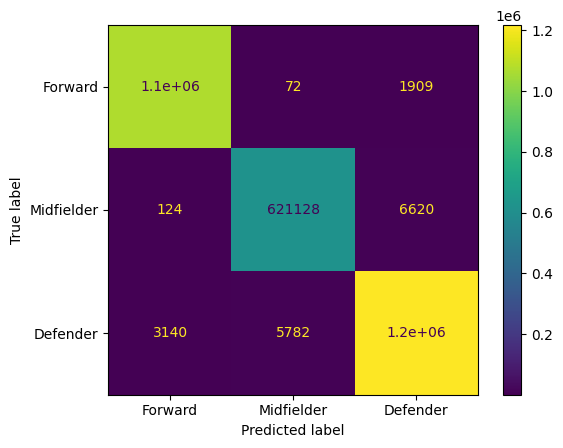

In [100]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,knn_predictions, ['Forward', 'Midfielder', 'Defender'])

#### Evaluate a model trained by Random Forest algorithm

[14:17:48.596337] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.907044  0.928578  0.917685  1.076063e+06
Forward        0.882934  0.787626  0.832561  6.278720e+05
Midfielder     0.835818  0.864602  0.849967  1.226248e+06
accuracy       0.871602  0.871602  0.871602  8.716019e-01
macro avg      0.875266  0.860269  0.866737  2.930183e+06
weighted avg   0.872071  0.871602  0.871105  2.930183e+06

Confusion Matrix


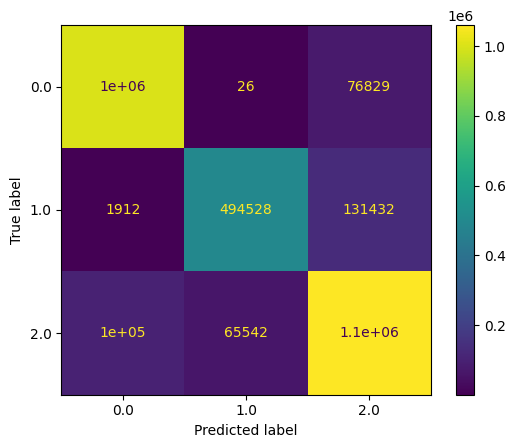

In [101]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,rf_predictions, [0.0,1.0,2.0])

#### Evaluate a model trained by Decision Tree algorithm

[14:19:21.711618] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.890546  0.896441  0.893484  1.076063e+06
Forward        0.877018  0.753139  0.810372  6.278720e+05
Midfielder     0.798378  0.851482  0.824075  1.226248e+06
accuracy       0.846920  0.846920  0.846920  8.469198e-01
macro avg      0.855314  0.833687  0.842644  2.930183e+06
weighted avg   0.849076  0.846920  0.846628  2.930183e+06

Confusion Matrix


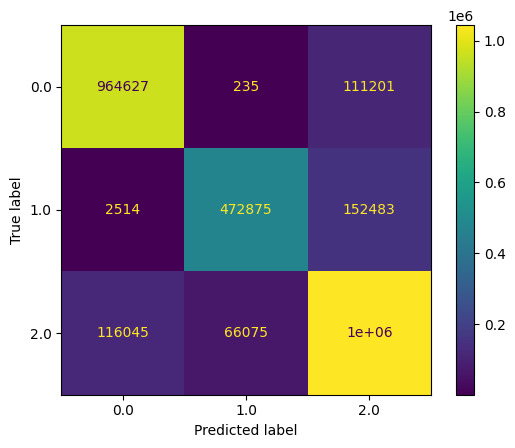

In [102]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,dt_predictions, [0.0,1.0,2.0])